# Contents
* [Objective](#objective)
* [Setup](#setup)
* [Data](#data)
* [Data Exploration](#data-exploration)
* [Research](#research)
* [Preprocessing](#preprocessing)
* [Model](#model)
* [Prediction](#prediction)
* [Run with Flask](#run-with-flask)

# Objective
The goal is to develop a model that can predict the pKi of a given compound against JAK1, JAK2, JAK3 and TYK2.

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mordred import Calculator, descriptors
from rdkit import Chem
from sklearn.preprocessing import MinMaxScaler
import pickle
import torch
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
df = pd.read_csv('./kinase_JAK.csv')
df

,SMILES,measurement_type,measurement_value,Kinase_name
0,C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...,pIC50,6.81,JAK2
1,C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...,pIC50,8.05,JAK1
2,C#CCN(c1ccc(C#N)cn1)C1CCN(c2ncnc3[nH]ccc23)C1,pIC50,10.26,JAK2
3,C#CCN(c1ccc(C#N)cn1)C1CCN(c2ncnc3[nH]ccc23)C1,pIC50,10.26,JAK1
4,C#CCNCC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1,pIC50,7.36,JAK2
...,...,...,...,...
10720,N#CCC1(n2cc(C(N)=O)c(Nc3ccnc(F)c3)n2)CCC(NCc2c...,pIC50,6.00,JAK2
10721,N#CCC1(n2cc(C(N)=O)c(Nc3ccnc(F)c3)n2)CCC(NCc2c...,pIC50,7.07,JAK1
10722,N#CC1CCCCC1n1cc(C(N)=O)c(Nc2ccnnc2)n1,pIC50,7.55,JAK2
10723,N#CC1CCCCC1n1cc(C(N)=O)c(Nc2ccnnc2)n1,pIC50,8.52,JAK1


# Data Exploration

<AxesSubplot:>

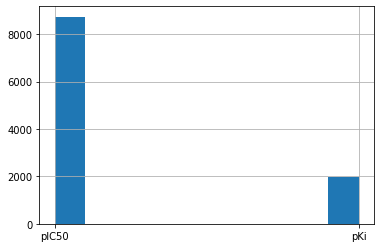

In [3]:
df['measurement_type'].hist()

We want to predict pKi, but it is a smaller subset of the total measurements.

Text(0.5, 1.0, 'pCI50 vs pKi')

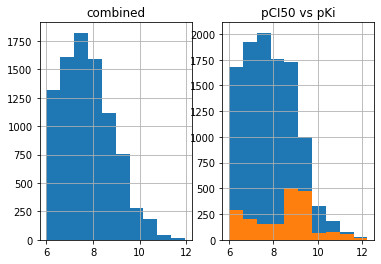

In [4]:
fig, axes = plt.subplots(1, 2)
df['measurement_value'].hist()
df[df['measurement_type']=='pIC50']['measurement_value'].hist(ax=axes[0])
df[df['measurement_type']=='pKi']['measurement_value'].hist(ax=axes[1])
axes[0].set_title('combined')
axes[1].set_title('pCI50 vs pKi')

pCI50 and pKi have similar enough distributions that we can treat them similarly but not the same. As we don't have a lot of pKi measurement_values, we want to enhance our dataset with pIC50 measurement_values. Hopefully, by treating the 'measurement_type' as a feature, the model can build an intuition between the two.

<AxesSubplot:>

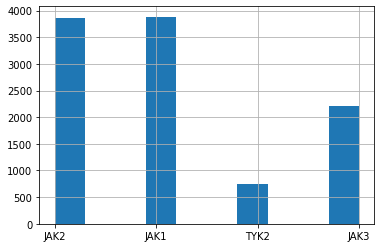

In [5]:
df['Kinase_name'].hist()

pKi against TYK2 kinase might be the hardest to predict given it has the lowest supporting data

# Research

Ki refers to inhibition constant for the binding of an inhibitor to an enzyme. The binding equilibrium depends on the mechanism of inhibition: competitive, uncompetitive, non-competitive, and mixed.
IC50 refers to the concentration of inhibitor required to reduce activity to 50% of the uninhibited value. These values are highly dependent on measurement conditions and are less precise than Ki.

https://www.sciencesnail.com/science/the-difference-between-ki-kd-ic50-and-ec50-values

Pinheiro et al show that we can predict molecular properties using SMILES which is advantagous due to its simplicity. Let's follow a similar approach.

https://www.researchgate.net/profile/Juarez-Da-Silva-2/publication/346029441_Machine_Learning_Prediction_of_Nine_Molecular_Properties_Based_on_the_SMILES_Representation_of_the_QM9_Quantum-Chemistry_Dataset/links/61ead5eb9a753545e2e847c5/Machine-Learning-Prediction-of-Nine-Molecular-Properties-Based-on-the-SMILES-Representation-of-the-QM9-Quantum-Chemistry-Dataset.pdf

# Preprocessing

In [6]:
# Generate dummies for 'measurement_type' and 'Kinase_name'
x = pd.concat([df, pd.get_dummies(df['Kinase_name'])], axis=1)
x = pd.concat([x, pd.get_dummies(df[['measurement_type']])], axis=1)

In [7]:
# Drop 'measurement_type' and  Kinase_name columns. 
# Also temporarily drop SMILES and set all data to same type.
x = x.drop(['measurement_type', 'Kinase_name', 'SMILES'], axis=1).astype('float32')
x['SMILES'] = df.SMILES
y = x['measurement_value']
x = x.drop(['measurement_value'], axis=1)
y = np.array(y).reshape(y.shape[0], 1)

Get Chem data

In [8]:
chem_calc = Calculator(descriptors, ignore_3D=True)
x['molecule'] = x['SMILES'].apply(Chem.MolFromSmiles)
x_descriptors = chem_calc.pandas(x['molecule'])

Select only numerical features with some sort of variance

In [9]:
descriptors_numeric = x_descriptors.select_dtypes(include='number').astype('float32')
descriptors_numeric = descriptors_numeric.loc[:, descriptors_numeric.var() > 0]

Combine descriptor data with original data and drop the no longer needed columns

In [10]:
features = pd.concat([x, descriptors_numeric], axis=1)
features.drop(['SMILES', 'molecule'], inplace=True, axis=1)

Save these feature columns for later

In [11]:
model_columns = pd.DataFrame({}, columns=features.columns)
model_columns.to_csv('model_assets/model_columns.csv', index=False)

Fit scaler to features and save for later inference

In [12]:
scaler = MinMaxScaler()
scaler.fit(features)
pickle.dump(scaler, open('model_assets/scaler.pkl', 'wb+'))

Load our scaler and model columns then scale features

In [13]:
scaler = pickle.load(open("model_assets/scaler.pkl", "rb"))
mol_columns = pd.read_csv('model_assets/model_columns.csv').columns
features_scaled = pd.DataFrame(scaler.transform(features), columns=model_columns.columns)

Make tensors from our features and targets

In [14]:
features_tensor = torch.tensor(features_scaled.values)
targets_tensor = torch.tensor(y)

# Create Dataloader

In [15]:
x_train, x_test, y_train, y_test = train_test_split(features_tensor, targets_tensor, test_size=0.2, random_state=1)

Update dataset class

In [16]:
class data_set(Dataset):
    def __init__(self, data_):
        self.data = data_
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, index):
        return self.data[index]

In [18]:
training_data = torch.utils.data.TensorDataset(x_train, y_train) 
testing_data = torch.utils.data.TensorDataset(x_test, y_test)

training_data = data_set(training_data)
testing_data = data_set(testing_data)
  
training_dataloader = DataLoader(training_data)
testing_dataloader = DataLoader(testing_data)

# Model

Use CPU or GPU

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Define model. Using a Sequential model with Linear and ReLU as found in literature.

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1303, 8580),
            nn.ReLU(),
            nn.Linear(8580, 1303),
            nn.ReLU(),
            nn.Linear(1303, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = x.float()
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1303, out_features=8580, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8580, out_features=1303, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1303, out_features=1, bias=True)
  )
)


Use 0.001 learning rate and Mean Squared Error for our loss function as seen in literature

In [21]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss() 

In [22]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.float()
        y = y.float()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss = loss.item()
            current_item = batch
            print(f'Loss: {loss:>5f}  currently at: {current_item:>5d}/{size:>5d}')

In [23]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error Avg loss: {test_loss:>5f}")

In [24]:
epochs = 5

In [25]:
for e in range(epochs):
    print(f"Epoch: {e+1}")
    print(f'Training {e+1}/{epochs}...')
    train(training_dataloader, model, loss_fn, optimizer)
    print(f'Testing {e+1}/{epochs}...')
    test(testing_dataloader, model, loss_fn)
print("Model is ready for predicting")

Epoch: 1
Training 1/5...
Loss: 68.300659  currently at:     0/ 8580
Loss: 0.000040  currently at:  1000/ 8580
Loss: 3.300686  currently at:  2000/ 8580
Loss: 4.208172  currently at:  3000/ 8580
Loss: 1.111478  currently at:  4000/ 8580
Loss: 0.505620  currently at:  5000/ 8580
Loss: 0.864030  currently at:  6000/ 8580
Loss: 0.012587  currently at:  7000/ 8580
Loss: 0.016317  currently at:  8000/ 8580
Testing 1/5...
Test Error Avg loss: 0.946322
Epoch: 2
Training 2/5...
Loss: 0.850176  currently at:     0/ 8580
Loss: 0.007352  currently at:  1000/ 8580
Loss: 4.027021  currently at:  2000/ 8580
Loss: 2.096168  currently at:  3000/ 8580
Loss: 0.691648  currently at:  4000/ 8580
Loss: 0.696616  currently at:  5000/ 8580
Loss: 0.927548  currently at:  6000/ 8580
Loss: 0.015455  currently at:  7000/ 8580
Loss: 0.005520  currently at:  8000/ 8580
Testing 2/5...
Test Error Avg loss: 0.870409
Epoch: 3
Training 3/5...
Loss: 0.709798  currently at:     0/ 8580
Loss: 0.003071  currently at:  1000/

The Mean Squared Error with 5 epoch is 0.699276 while 3 epochs was 0.83887, so training with even higher epochs should lead to a better model

In [29]:
model_scripted = torch.jit.script(model)
model_scripted.save('model_assets/model_scripted.pt')

# Prediction

In [30]:
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1303, out_features=8580, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8580, out_features=1303, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1303, out_features=1, bias=True)
  )
)

In [31]:
with torch.no_grad():
    predictions = model(x_test)
predictions

tensor([[6.2800],
        [6.9250],
        [7.7473],
        ...,
        [6.9301],
        [8.6558],
        [8.0567]])

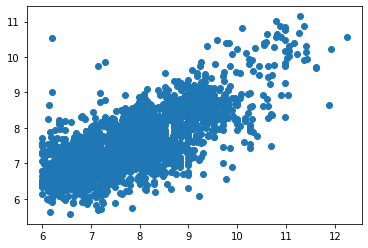

In [32]:
plt.scatter(y_test, predictions)

Seems like our predictions aren't terrible!

### Predict against Kinases

Choose an example SMILE

In [33]:
input_smile = df.iloc[0]['SMILES']
df.iloc[0]

SMILES               C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...
measurement_type                                                 pIC50
measurement_value                                                 6.81
Kinase_name                                                       JAK2
Name: 0, dtype: object

Get molecular description data

In [34]:
mol = Chem.MolFromSmiles(input_smile)
input_features = chem_calc.pandas([mol])

We want to make predictions against 4 Kinases. We can do this by creating 4 samples with the same molecular features but each with a different Kinase.

In [35]:
input_features = pd.concat([input_features]*4)
input_features[['JAK1', 'JAK2', 'JAK3', 'TYK2']] = np.diag([1,1,1,1])
# We're only interested in pKi so we'll set pIC50 to zero
input_features[['measurement_type_pIC50', 'measurement_type_pKi']] = [0,1]
input_features = input_features[mol_columns]
input_features


,JAK1,JAK2,JAK3,TYK2,measurement_type_pIC50,measurement_type_pKi,ABC,ABCGG,nAcid,nBase,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,1,0,0,0,0,1,23.569882,18.453764,0,0,...,10.214532,80.482278,424.165917,8.157037,2959,47,156.0,181.0,10.861111,7.055556
0,0,1,0,0,0,1,23.569882,18.453764,0,0,...,10.214532,80.482278,424.165917,8.157037,2959,47,156.0,181.0,10.861111,7.055556
0,0,0,1,0,0,1,23.569882,18.453764,0,0,...,10.214532,80.482278,424.165917,8.157037,2959,47,156.0,181.0,10.861111,7.055556
0,0,0,0,1,0,1,23.569882,18.453764,0,0,...,10.214532,80.482278,424.165917,8.157037,2959,47,156.0,181.0,10.861111,7.055556


Now scale and make it a tensor

In [36]:
scaled_input_features = pd.DataFrame(scaler.transform(input_features), columns=mol_columns)
tensor_input_features = torch.tensor(scaled_input_features.values)

Load our Model

In [37]:
loaded_model = torch.jit.load('model_assets/model_scripted.pt')

Predict

In [40]:
loaded_model.eval()

RecursiveScriptModule(
  original_name=NeuralNetwork
  (flatten): RecursiveScriptModule(original_name=Flatten)
  (linear_relu_stack): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=Linear)
  )
)

In [41]:
with torch.no_grad():
    result = loaded_model(tensor_input_features)

In [42]:
for kinase, r in zip(['JAK1', 'JAK2', 'JAK3', 'TYK2'], torch.flatten(result)):
    print(kinase, 'kPi:', r.item())

JAK1 kPi: 8.2319917678833
JAK2 kPi: 7.448752403259277
JAK3 kPi: 7.485004425048828
TYK2 kPi: 7.216372489929199


Our model is able to predict pKi's for a given molecule against different kinases!

# Run with Flask

Next, lets host this model locally with Flask. 

Steps:
1. Run the next cell
1. Visit http://127.0.0.1:5001
1. Enter a SMILE such as CC(=O)SCC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1
1. Interrupt this kernel to stop the server.

In [45]:
# You'll need to interrupt the kernel to stop this
%run local_app.py

 * Serving Flask app 'local_app' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5001 (Press CTRL+C to quit)
127.0.0.1 - - [06/Jun/2022 18:57:27] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Jun/2022 18:57:33] "POST /result HTTP/1.1" 200 -


SUCCESS!


# Next Steps

Let's push this to the cloud! 
You can use the Dockerfile and setup.sh file to setup our SMILE predictor on an AWS EC2...

or you can visit it live at: http://44.224.22.163:5000/

[back-to-top](#contents)